# Preparing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import Input
from keras.models import Model
from keras.layers import Dense, LSTM, Conv1D, Conv2D,\
              Dropout, BatchNormalization, Flatten, Reshape, Concatenate, Bidirectional

In [ ]:
!gdown 12KgRkqQ1zb_xqP22CbRZozIqpbIRMU2J
!gdown 1ZPnD9XJAQdAmtZ4PJWochdHaMXE24vAa
!gdown 1LSOMo1WIFaImACF5ufThX5zc7lG-kXVy

Downloading...
From: https://drive.google.com/uc?id=12KgRkqQ1zb_xqP22CbRZozIqpbIRMU2J
To: /content/light_train_source_labels.csv
100% 126M/126M [00:03<00:00, 41.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZPnD9XJAQdAmtZ4PJWochdHaMXE24vAa
To: /content/light_train_target_labels.csv
100% 3.58M/3.58M [00:00<00:00, 153MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LSOMo1WIFaImACF5ufThX5zc7lG-kXVy
To: /content/light_test_source_labels.csv
100% 31.6M/31.6M [00:00<00:00, 94.0MB/s]


In [ ]:
train_source = pd.read_csv("light_train_source_labels.csv")
train_target = pd.read_csv("light_train_target_labels.csv")
test_source = pd.read_csv("light_test_source_labels.csv")

## Define Functions

In [ ]:
def Draw_Loss_Acc(history):
  fig, ax = plt.subplots(1, 2, figsize=(10, 5))

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)
  ax[0].plot(epochs, loss, 'b', label='Training loss')
  ax[0].plot(epochs, val_loss, 'r', label='Validation loss')
  ax[0].set_title('Training and validation loss')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend()

  auc = history.history['auc']
  val_auc = history.history['val_auc']
  ax[1].plot(epochs, auc, 'b', label='Training acc')
  ax[1].plot(epochs, val_auc, 'r', label='Validation acc')
  ax[1].set_title('Training and validation accuracy')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

In [ ]:
def Test_Functional_Model(epochs):
  model = Construct_Functional_Model()

  history = model.fit(x_train, y_train, batch_size=256, epochs=epochs, validation_data=(x_valid, y_valid))

  print("\nLocal Test:")
  model.evaluate(x_test, y_test)

  print("\n\nLoss/AUC Graph:")
  Draw_Loss_Acc(history)

  return model, history

In [ ]:
def Refit_Model(epochs):
  model = Construct_Functional_Model()
  history = model.fit(X, y, batch_size=256, epochs=epochs)

  return model, history

## Load Data

In [ ]:
X = train_source.iloc[:, 1:].to_numpy()
y = train_target.iloc[:, 1:].to_numpy()

# train : valid : test = 0.8 : 0.1 : 0.1
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=0)

# Training

## Model Structure

### LSTM

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))
  reshaped = Reshape((37, 28))(input)

  lstm_1 = LSTM(48, dropout=0.375, recurrent_dropout=0.375, return_sequences=True)(reshaped)
  lstm_2 = LSTM(48, dropout=0.375, recurrent_dropout=0.375, return_sequences=True)(lstm_1)
  predictions = LSTM(28, activation='sigmoid')(lstm_2)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

### LSTM + NN

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))
  reshaped = Reshape((37, 28))(input)

  lstm = LSTM(48, dropout=0.375)(reshaped)
  nn = Dense(128, activation='sigmoid')(lstm)
  predictions = Dense(28, activation='sigmoid')(nn)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

#### Model Y

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))
  reshaped = Reshape((37, 28))(input)

  lstm_1 = LSTM(24, dropout=0.375)(reshaped)
  lstm_2 = LSTM(24, dropout=0.375)(reshaped)

  merged = Concatenate()([lstm_1, lstm_2])
  nn = Dense(96, activation='relu')(merged)

  predictions = Dense(28, activation='sigmoid')(nn)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC(1000)])
  print(model.summary())
  return model

### 1D-CNN

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))
  reshaped = Reshape((259, 4))(input)

  cnn_1 = Conv1D(filters=32, kernel_size=32, strides=2, activation='relu', padding="same", data_format="channels_last")(reshaped)
  drop_1 = Dropout(0.5)(cnn_1)
  cnn_2 = Conv1D(filters=16, kernel_size=32, strides=2, activation='sigmoid', padding="same", data_format="channels_last")(drop_1)
  drop_2 = Dropout(0.5)(cnn_2)

  flatten = Flatten()(drop_2)

  predictions = Dense(28, activation='sigmoid')(flatten)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

### 2D-CNN + LSTM

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))
  reshaped = Reshape((37, 7, 4))(input)

  cnn_1 = Conv2D(filters=32, kernel_size=(16, 1), strides=(2, 1), activation='relu', padding="same", data_format="channels_last")(reshaped)
  drop_1 = Dropout(0.5)(cnn_1)
  cnn_2 = Conv2D(filters=16, kernel_size=(16, 1), strides=(2, 1), activation='relu', padding="same", data_format="channels_last")(drop_1)
  drop_2 = Dropout(0.5)(cnn_2)
  reshaped_1 = Reshape((10, 7*16))(drop_2)
  lstm = LSTM(32, dropout=0.375, recurrent_dropout=0.375)(reshaped_1)

  predictions = Dense(28, activation='sigmoid')(lstm)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

### Ultra CNN (1D-CNN + 2D-CNN)

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))

  reshaped_1 = Reshape((259, 4))(input)
  cnn_11 = Conv1D(filters=32, kernel_size=32, strides=2, activation='relu', padding="same", data_format="channels_last")(reshaped_1)
  drop_11 = Dropout(0.5)(cnn_11)
  cnn_12 = Conv1D(filters=16, kernel_size=16, strides=2, activation='sigmoid', padding="same", data_format="channels_last")(drop_11)
  drop_12 = Dropout(0.5)(cnn_12)
  flatten_1 = Flatten()(drop_12)

  reshaped_2 = Reshape((37, 7, 4))(input)
  cnn_21 = Conv2D(filters=32, kernel_size=(16, 1), strides=(2, 1), activation='relu', padding="same", data_format="channels_last")(reshaped_2)
  drop_21 = Dropout(0.5)(cnn_21)
  cnn_22 = Conv2D(filters=16, kernel_size=(16, 1), strides=(2, 1), activation='sigmoid', padding="same", data_format="channels_last")(drop_21)
  drop_22 = Dropout(0.5)(cnn_22)
  flatten_2 = Flatten()(drop_22)

  merged = Concatenate()([flatten_1, flatten_2])
  nn = Dense(128, activation='sigmoid')(merged)
  drop = Dropout(0.5)(nn)
  predictions = Dense(28, activation='sigmoid')(drop)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

In [ ]:
def CNN_Week(input, num_of_filters, num_of_weeks):
  cnn = Conv1D(filters=num_of_filters, kernel_size=num_of_weeks*7, strides=7, activation='relu', padding='same', data_format='channels_last')(input)
  return Dropout(0.5)(cnn)

def CNN_1D(input):

  cnn_2 = CNN_Week(Reshape((259, 4))(input), 16, 2)
  cnn_3 = CNN_Week(Reshape((259, 4))(input), 16, 3)
  cnn_4 = CNN_Week(Reshape((259, 4))(input), 16, 4)

  lstm = LSTM(32, dropout=0.375, recurrent_dropout=0.375, return_sequences=True)(Reshape((37, 28))(input))
  merged = Concatenate(axis=-1)([cnn_2, cnn_3, cnn_4, lstm])

  predictions = LSTM(28, activation='sigmoid')(merged)

  return predictions

def CNN_2D(input):
  reshaped = Reshape((37, 7, 4))(input)

  cnn_1 = Conv2D(filters=32, kernel_size=(16, 1), strides=(2, 1), activation='relu', padding="same", data_format="channels_last")(reshaped)
  drop_1 = Dropout(0.5)(cnn_1)
  cnn_2 = Conv2D(filters=16, kernel_size=(16, 1), strides=(2, 1), activation='relu', padding="same", data_format="channels_last")(drop_1)
  drop_2 = Dropout(0.5)(cnn_2)

  reshaped_1 = Reshape((10, 7*16))(drop_2)
  lstm = LSTM(32, dropout=0.375, recurrent_dropout=0.375, return_sequences=True)(reshaped_1)

  predictions = LSTM(28, activation='sigmoid')(lstm)

  return predictions


def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))

  cnn_1 = CNN_1D(input)
  cnn_2 = CNN_2D(input)

  merged = Concatenate()([cnn_1, cnn_2])
  predictions = Dense(28, activation='sigmoid')(merged)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

In [ ]:
def Construct_Functional_Model():
  tf.keras.backend.clear_session()


  # Model Structure
  input = Input(shape=(1036))

  reshaped_1 = Reshape((259, 4))(input)
  cnn_11 = Conv1D(filters=32, kernel_size=35, strides=7, activation='relu', padding="same", data_format="channels_last")(reshaped_1)
  drop_11 = Dropout(0.5)(cnn_11)
  cnn_12 = Conv1D(filters=16, kernel_size=35, strides=1, activation='sigmoid', padding="same", data_format="channels_last")(drop_11)
  drop_12 = Dropout(0.5)(cnn_12)
  flatten_1 = Flatten()(drop_12)

  reshaped_2 = Reshape((37, 7, 4))(input)
  cnn_21 = Conv2D(filters=32, kernel_size=(16, 1), strides=(2, 1), activation='relu', padding="same", data_format="channels_last")(reshaped_2)
  drop_21 = Dropout(0.5)(cnn_21)
  cnn_22 = Conv2D(filters=16, kernel_size=(16, 1), strides=(2, 1), activation='sigmoid', padding="same", data_format="channels_last")(drop_21)
  drop_22 = Dropout(0.5)(cnn_22)
  flatten_2 = Flatten()(drop_22)

  merged = Concatenate()([flatten_1, flatten_2])
  nn = Dense(128, activation='sigmoid')(merged)
  drop = Dropout(0.5)(nn)
  predictions = Dense(28, activation='sigmoid')(drop)

  model = Model(input, predictions)
  # Model Structure


  model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=[keras.metrics.AUC()])
  print(model.summary())
  return model

## Training, Validating, and Testing

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1036)]               0         []                            
                                                                                                  
 reshape (Reshape)           (None, 259, 4)               0         ['input_1[0][0]']             
                                                                                                  
 reshape_1 (Reshape)         (None, 37, 7, 4)             0         ['input_1[0][0]']             
                                                                                                  
 conv1d (Conv1D)             (None, 37, 32)               4512      ['reshape[0][0]']             
                                                                                              

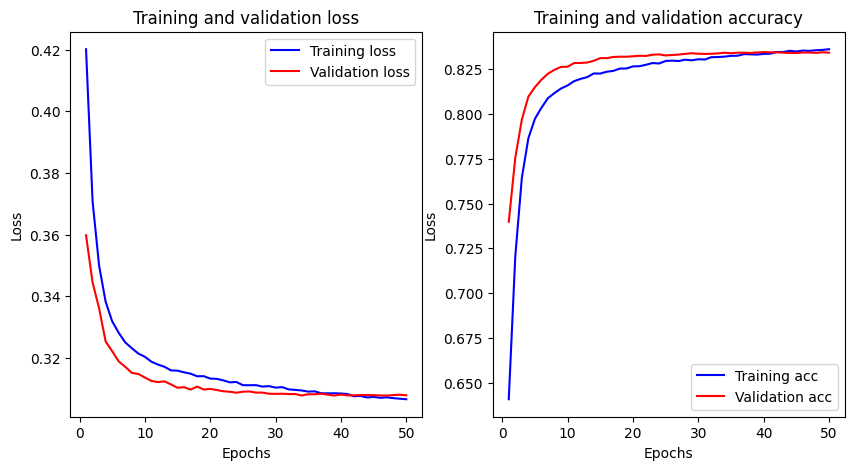

In [ ]:
epochs = 50
model, history = Test_Functional_Model(epochs)

# Output Prediciton

## Refit on All Data

In [ ]:
model, history = Refit_Model(epochs)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1036)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 37, 28)       0           ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    (None, 37, 32)       7808        ['reshape[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 37, 32)       7808        ['reshape[0][0]']                
                                                                                              

## Predict

In [ ]:
output = model.predict(test_source.iloc[:, 1:].to_numpy())

col = [f"time_slot_{i}" for i in range(28)]
df = pd.DataFrame(output, columns=col)
df = pd.concat([test_source.iloc[:, 0], df], axis=1)

df.to_csv("Dual_LSTM_(32, sigmoid).csv", index=False)

238/238 [==============================] - 4s 18ms/step
